In [1]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import wraps
from cycler import cycler
from itertools import cycle

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

%matplotlib inline

In [2]:
mpl.rcParams['figure.dpi'] = 120

# B&O Model Checking Implementation

Bastos & O'Hagan provided a great set of diagnostic tools for testing whether or not a Gaussian process (GP) is a reasonable emulator for an expensive simulator. Our use case is slightly different than theirs. We don't necessarily care about our GPs matching some underlying simulator. Rather, given a set of curves from a hierarchy of simulators, we wish to answer the following questions:
1. Can they reasonably be assumed to be drawn from the same underlying Gaussian process?
2. If so, which Gaussian process?
3. The underlying GP is later used as a model discrepancy, so how can we test its performance against experiment?

These three questions may or may not be decided by diagnostics discussed in B&O, but to find out we must implement their methods!
That is what this notebook aims to do.

## Model Checking for GPs

Let's start with model checking diagnostics that assumes everything is Gaussian. We don't need to integrate out parameters yet, and instead be content with MAP values for now.

Here are some utility functions that will prove useful later.

In [3]:
def lazy_property(function):
    R"""Stores as a hidden attribute if it doesn't exist yet, else it returns the hidden attribute.
    
    This means that any method decorated with this function will only be computed if necessary, and will be
    stored if needed to be called again.
    """
    attribute = '_cache_' + function.__name__

    @property
    @wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            setattr(self, attribute, function(self))
        return getattr(self, attribute)

    return decorator


def chol_errors(y, mean, chol):
        return sp.linalg.solve_triangular(chol, (y - mean).T, lower=True).T


def mahalanobis(y, mean, chol):
    err = chol_errors(y, mean, chol)
    return np.linalg.norm(err, axis=-1)

Now let's define a GP class that behaves like `GaussianProcessRegressor` in `scikit-learn`, but analytically computes MAP values for means and covariances when multiple iid curves are examined.

In [4]:
class GP:
    
    def __init__(self, corr_kernel, m0=0, v0=1, a0=1, b0=1):
        """A conjugate Gaussian Process model
        
        Parameters
        ----------
        corr_kernel : callable
            The kernel for the correlation matrix
        m0 : float
            The mean hyperparameter for the normal prior placed on the mean
        v0 : float
            The variance hyperparameter for the normal prior placed on the mean
        a0 : float > 0
            The shape hyperparameter for the inverse gamma prior placed on sd**2
        b0 : float > 0
            The scale hyperparameter for the inverse gamma prior placed on sd**2
        """
        self.m0 = m0
        self.v0 = v0
        self.a0 = a0
        self.b0 = b0
        self.corr_kernel = corr_kernel
        self.y = None
    
    def cleanup(self):
        """Removes all attributes except those set at initialization"""
        def attr_name(name):
            return '_cache_' + name
        for attr in ['y', 'X', 'corr']:
            try:
                delattr(self, attr)
            except AttributeError:
                pass
        for attr in ['m', 'v', 'a', 'b', 'sd', 'corr_chol']:
            try:
                delattr(self, attr_name(attr))
            except AttributeError:
                pass
    
    @lazy_property
    def m(self):
        """The posterior mean hyperparameter given y for the normal prior placed on the GP mean"""
        y = self.y
        if self.v0 == 0:  # Do by hand to prevent dividing by zero
            return self.m0
        else:
            y_avg = y
            if y.ndim == 2:
                y_avg = np.average(y, axis=0)
            one = np.ones_like(y_avg)
            right_half = chol_errors(y_avg, 0, self.corr_chol)
            left_half = chol_errors(one, 0, self.corr_chol)
            return self.v * (self.m0 / self.v0 + self.nc * np.dot(left_half.T, right_half))
    
    @lazy_property
    def v(self):
        """The posterior variance hyperparameter for the normal prior placed on the mean"""
        y = self.y
        if self.v0 == 0:  # Do by hand to prevent dividing by zero
            return 0
        else:
            one = np.ones(self.corr_chol.shape[-1])
            quad = mahalanobis(one, 0, self.corr_chol)**2
            return (1. / self.v0 + self.nc * quad) ** (-1)
    
    @lazy_property
    def a(self):
        """The posterior shape hyperparameter for the inverse gamma prior placed on sd**2"""
        y = self.y
        return self.a0 + y.size / 2.
    
    @lazy_property
    def b(self):
        """The posterior scale hyperparameter for the inverse gamma prior placed on sd**2"""
        y = self.y
        mean_terms = 0
        if self.v0 != 0:
            mean_terms = self.m0**2 / self.v0 - self.m**2 / self.v
        quad = np.sum(mahalanobis(y, 0, self.corr_chol)**2)
        return self.b0 + 0.5 * (mean_terms + quad)
    
    # @lazy_property
    # def corr_chol(self):
    #     return np.linalg.cholesky(self.corr)
    
    @lazy_property
    def sd(self):
        """The MAP value for the standard deviation given y"""
        return np.sqrt(self.b / (self.a - 1))

    def mean(self, X=None):
        """The MAP value for the mean given y"""
        if X is None:
            X = self.X
        return self.m * np.ones(len(X))

    def cov(self, X=None, Xp=None):
        if X is None:
            X = self.X
        if Xp is None:
            Xp = self.X
        return self.sd**2 * self.corr_kernel(X, Xp)
    
    def fit(self, X, y, noise_sd=1e-15):
        """Fits the GP, i.e., sets/updates all hyperparameters, given y(X)"""
        self.cleanup()
        self.X = X
        self.y = y
        self.nc = 1
        if y.ndim == 2:
            self.nc = y.shape[0]
        self.corr = self.corr_kernel(X)
        self.corr_chol = np.linalg.cholesky(self.corr + noise_sd**2 * np.eye(len(X)))
        self.noise_sd = noise_sd
        self.mean
        self.cov
    
    def predict(self, Xnew, y=None):
        """Returns the predictive GP at unevaluated points Xnew"""
        if y is None:
            y = self.y
        m_old = self.mean()
        m_new = self.mean(Xnew)
        K_on = self.cov(self.X, Xnew)
        K_no = K_on.T
        K_nn = self.cov(Xnew, Xnew)

        mfilter = np.dot(K_no, sp.linalg.cho_solve((self.corr_chol, True), (y - m_old).T)).T / self.sd**2
        m_pred = m_new + mfilter
        half_quad = sp.linalg.solve_triangular(self.corr_chol, K_on, lower=True) / self.sd
        K_pred = K_nn - np.dot(half_quad.T, half_quad)
        return m_pred, K_pred

The above class will output the relevant mean and covariance arrays that we will need for model checking, so below we define a class that will take $m$ and $\Sigma$ and compute B&O diagnostics.

In [5]:
class GPModelChecking:
    R"""A class for quickly testing model checking methods discussed in Bastos & O'Hagan.
    
    """
    
    def __init__(self, mean, cov):
        self.mean = mean
        self.cov = cov
        self.dist = stats.multivariate_normal(mean=mean, cov=cov)
        self.udist = stats.norm(loc=mean, scale=np.sqrt(np.diag(cov)))
        
    @lazy_property
    def chol(self):
        """Returns the lower cholesky matrix G where cov = G.G^T"""
        return np.linalg.cholesky(self.cov)
    
    @lazy_property
    def pivoted_chol(self):
        """Returns the pivoted cholesky matrix G where cov = G.G^T"""
        raise NotImplementedError
    
    @lazy_property
    def eig(self):
        """Returns the eigen-docomposition matrix G where cov = G.G^T"""
        e, v = np.linalg.eigh(self.cov)
        ee = np.diag(np.sqrt(e))
        return np.dot(v, ee)

    def samples(self, n):
        return self.dist.rvs(n)
    
    def indiv_errors(self, y):
        return (y - self.mean) / np.sqrt(np.diag(self.cov))
    
    def chol_errors(self, y):
        return chol_errors(y, self.mean, self.chol)
    
    def eig_errors(self, y):
        return np.linalg.solve(self.eig, (y - self.mean).T).T
    
    def pivoted_chol_errors(self, y):
        raise NotImplementedError
    
    def chi2(self, y):
        return np.sum(self.indiv_errors(y), axis=-1)

    def md(self, y):
        R"""The Mahalanobis distance"""
        return mahalanobis(y, self.mean, self.chol)

    def kl(self, mean, cov):
        R"""The Kullbeck-Leibler divergence"""
        m1, c1, chol1 = self.mean, self.cov, self.chol
        m0, c0 = mean, cov
        tr = np.trace(sp.linalg.cho_solve((chol1, True), c0))
        dist = self.md(m0) ** 2
        k = c1.shape[-1]
        logs = np.sum(np.log(np.diag(c1))) - np.sum(np.log(np.diag(c0)))
        return 0.5 * (tr + dist - k + logs)
    
    def credible_interval(self, y, intervals):
        """The credible interval diagnostic.
        
        Parameters
        ----------
        y : (n_c, d) shaped array
        intervals : 1d array
            The credible intervals at which to perform the test
        """
        lower, upper = self.udist.interval(np.atleast_2d(intervals).T)
        
        def diagnostic(data, lower, upper):
            indicator = (lower < data) & (data < upper)  # 1 if in, 0 if out
            return np.average(indicator, axis=1)   # The diagnostic

        dci = np.apply_along_axis(
                diagnostic, axis=1, arr=np.atleast_2d(y), lower=lower,
                upper=upper)
        dci = np.squeeze(dci)
        return dci

We will probably end up plotting these diagnostics in similar ways throughout the notebook, so let's define these functions up front.

In [6]:
class GraphicalDiagnostic:
    
    def __init__(self, diagnostic, data, nref=1000, colors=None):
        self.diagnostic = diagnostic
        self.data = data
        self.samples = self.diagnostic.samples(nref)
        if colors is None:
            # The standard Matplotlib 2.0 colors, or whatever they've been updated to be.
            clist = list(mpl.rcParams['axes.prop_cycle'])
            colors = [c['color'] for c in clist]
        self.colors = colors
        self.color_cycle = cycler('color', colors)
    
    def error_plot(self, err, title=None, ylabel=None, ax=None):
        if ax is None:
            ax = plt.gca()
        ax.axhline(0, 0, 1, linestyle='-', color='k', lw=1)
        # The 2 sigma bands since the sd has been divided out.
        ax.axhline(-2, 0, 1, linestyle='--', color='gray')
        ax.axhline(2, 0, 1, linestyle='--', color='gray')
        ax.set_prop_cycle(self.color_cycle)
        ax.plot(np.arange(self.data.shape[-1]), err.T, ls='', marker='o')
        ax.set_xlabel('index')
        if ylabel is not None:
            ax.set_ylabel(ylabel)
        if title is not None:
            ax.set_title(title)
        return ax
    
    def indiv_errors(self, ax=None):
        err = self.diagnostic.indiv_errors(self.data)
        return self.error_plot(err, title='Individual Errors', ax=ax)
    
    def chol_errors(self, ax=None):
        err = self.diagnostic.chol_errors(self.data)
        return self.error_plot(err, title='Cholesky Decomposed Errors', ax=ax)
    
    def eig_errors(self, ax=None):
        err = self.diagnostic.eig_errors(self.data)
        return self.error_plot(err, title='Eigen Decomposed Errors', ax=ax)
    
    def hist(self, data, ref, title=None, xlabel=None, ylabel=None, ax=None):
        ref_stats = stats.describe(ref)
        ref_sd = np.sqrt(ref_stats.variance)
        ref_mean = ref_stats.mean

        if ax is None:
            ax = plt.gca()
        ax.hist(ref, density=False, label='ref', histtype='step', color='k')
        ax.vlines([ref_mean - ref_sd, ref_mean + ref_sd], 0, 1, color='gray',
                  linestyle='--', transform=ax.get_xaxis_transform(), label='68%')
        for c, d in zip(cycle(self.color_cycle), np.atleast_1d(data)):
            ax.axvline(d, 0, 1, zorder=50, **c)
        ax.legend()
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        if ylabel is not None:
            ax.set_ylabel(ylabel)
        return ax
    
    def md(self, ax=None):
        if ax is None:
            ax = plt.gca()
        md_data = self.diagnostic.md(self.data)
        md_ref = self.diagnostic.md(self.samples)
        return self.hist(md_data, md_ref, title='Mahalanobis Distance', xlabel='MD', ylabel='counts', ax=ax)
    
    def kl(self, X, gp, predict=False, ax=None):
        if ax is None:
            ax = plt.gca()
        ref_means = []
        ref_covs = []
        for i, sample in enumerate(self.samples):
            gp.fit(X, sample)
            if predict:
                mean, cov = gp.predict(X)
            else:
                mean, cov = gp.mean(X), gp.cov(X)
            ref_means.append(mean)
            ref_covs.append(cov)
            
        data_means = []
        data_covs = []
        for i, data in enumerate(np.atleast_2d(self.data)):
            gp.fit(X, data)
            if predict:
                mean, cov = gp.predict(X)
            else:
                mean, cov = gp.mean(X), gp.cov(X)
            data_means.append(mean)
            data_covs.append(cov)
        
        kl_ref = [self.diagnostic.kl(mean, cov) for mean, cov in zip(ref_means, ref_covs)]
        kl_data = [self.diagnostic.kl(mean, cov) for mean, cov in zip(data_means, data_covs)]
        return self.hist(kl_data, kl_ref, title='KL Divergence', xlabel='KL', ylabel='counts', ax=ax)
    
    def credible_interval(self, intervals, band_perc, ax=None):
        dci_data = self.diagnostic.credible_interval(self.data, intervals)
        dci_ref = self.diagnostic.credible_interval(self.samples, intervals)
        bands = np.array([np.percentile(dci_ref, [100*(1.-bi)/2, 100*(1.+bi)/2], axis=0)
                          for bi in band_perc])
        if ax is None:
            ax = plt.gca()
        for i in range(len(band_perc)-1, -1, -1):
            ax.fill_between(intervals, bands[i, 0], bands[i, 1], alpha=0.5, color='gray')
        
        ax.plot([0, 1], [0, 1], c='k')
        ax.set_prop_cycle(self.color_cycle)
        ax.plot(intervals, dci_data.T)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_ylabel('Empirical Coverage')
        ax.set_xlabel('Credible Interval')
        return ax
    
    def plotzilla(self, X, gp=None, predict=False):
        if gp is None:
            pass
        fig, axes = plt.subplots(2, 3, figsize=(12, 6))
        self.md(axes[0, 0])
        self.kl(X, gp, predict, axes[0, 1])
        self.credible_interval(np.linspace(0, 1, 101), [0.68, 0.95], axes[0, 2])
        self.indiv_errors(axes[1, 0])
        self.chol_errors(axes[1, 1])
        self.eig_errors(axes[1, 2])
        fig.tight_layout()
        return fig, axes


## The Model

Begin by drawing a set of curves from a GP, then pick a set of points to fit to. Below are the parameters one might want to adjust:

In [7]:
X_full = np.atleast_2d(np.linspace(0, 10, 41)).T
mask = np.array([i % 8 == 0 for i in range(len(X_full))])

n_samples = 4
n_ref = 1000
seed = 2
nugget_sd = 1e-4
true_kernel = C(1.0, (1e-3, 1e3)) * RBF(3, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)

Given the above parameters, we can start by sampling curves and masking down to a reasonable training set.

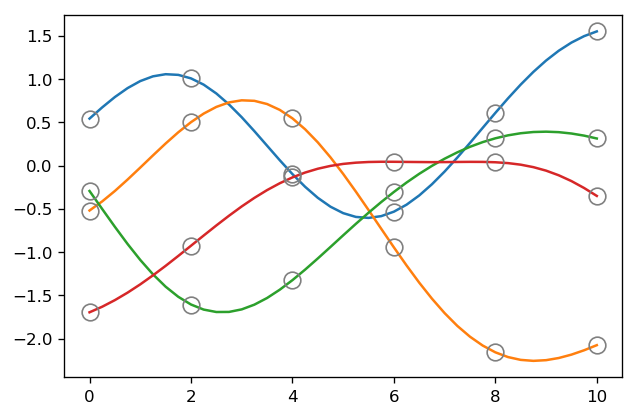

In [8]:
# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=true_kernel, n_restarts_optimizer=9, optimizer=None)
toy_data_full = gp.sample_y(X_full, n_samples=n_samples, random_state=seed).T
mean_full, cov_full = gp.predict(X_full, return_cov=True)

toy_data = toy_data_full[:, mask]
mean = mean_full[mask]
cov = cov_full[mask][:, mask]
X = X_full[mask]

plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

Now if we take the data shown above, estimate the hyperparameters using conjugacy, and fit to the data, we get the plot shown below:

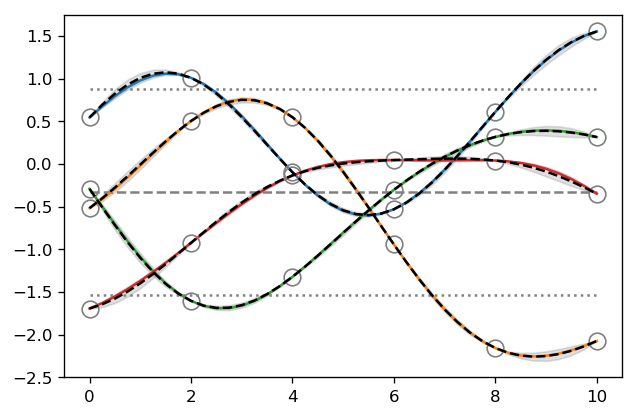

In [9]:
# kernel = C(1.0, (1e-3, 1e3)) * RBF(3, (1e-2, 1e2)) + WhiteKernel(1e-8)
kernel = true_kernel
my_gp = GP(kernel)
my_gp.fit(X, toy_data)
X_new = X_full
m_pred, K_pred = my_gp.predict(X_new)
# print(np.diag(K_pred))
sd_pred = np.sqrt(np.diag(K_pred))

# Plot the underlying process
plt.plot(X.ravel(), my_gp.mean(), ls='--', c='gray')
plt.plot(X.ravel(), my_gp.mean() + my_gp.sd, ls=':', c='gray')
plt.plot(X.ravel(), my_gp.mean() - my_gp.sd, ls=':', c='gray');

# Now the true data
plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

# The predicted interpolants and their errors
plt.plot(X_new.ravel(), m_pred.T, c='k', ls='--', label='pred');
for m in m_pred:
    plt.fill_between(X_new.ravel(), m + 2*sd_pred, m - 2*sd_pred, color='gray', alpha=0.25)
# plt.legend();

It worked! The mean and standard deviation are determined fairly well from the data. Not only that, the fits seem to interpolate in a reasonable manner. This should be expected, since the toy data were generated from a single GP whose kernel was assumed to be known. Plus, the length scale was fixed at the correct value.

We can do better than these "by eye" checks. What does B&O model checking say about this case? First, assume that we are checking the underlying process, shown by the constant gray dotted/dashed lines above, against the colored draws.

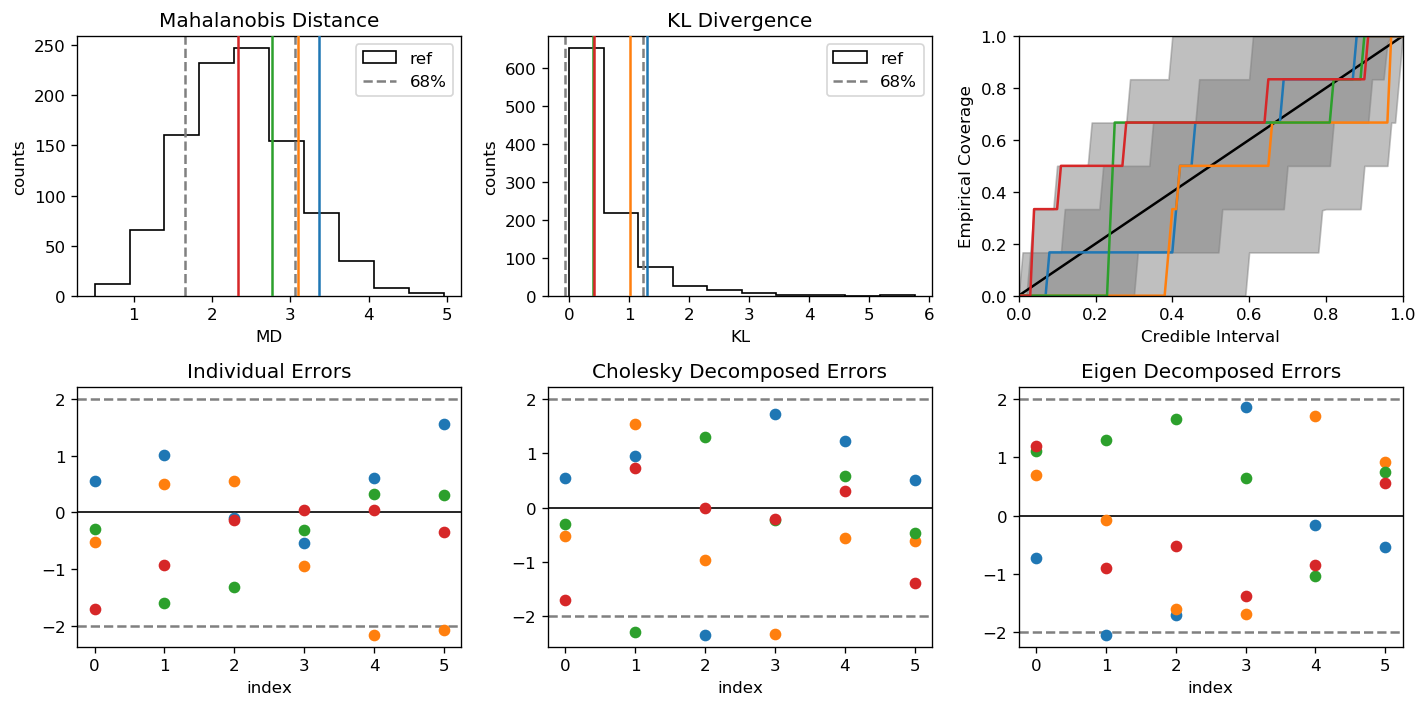

In [10]:
np.random.seed(seed)
gp = GP(kernel)
gpmc = GPModelChecking(mean, cov)
gd = GraphicalDiagnostic(gpmc, toy_data, nref=n_ref)
gd.plotzilla(X, gp);

They each are within errors, as expected.

What if we use the full dataset?

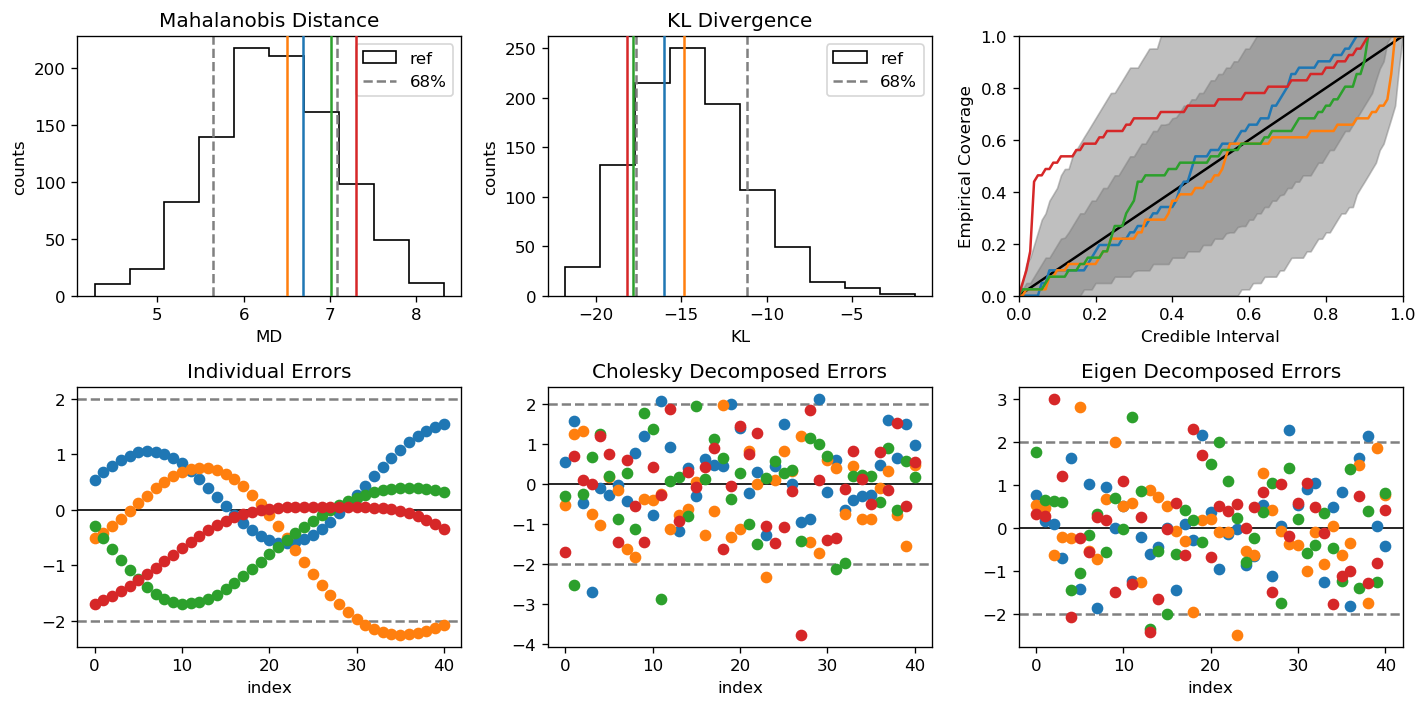

In [11]:
gpmc_full = GPModelChecking(mean_full, cov_full)
gd_full = GraphicalDiagnostic(gpmc_full, toy_data_full, nref=n_ref)
gd_full.plotzilla(X_full, gp);

What if we performed the same model checking with the interpolants?
This time, we are comparing each colored curve to the process defined by the thin gray bands around that curve.
One potential clever way to combine the diagnostics from interpolated processes relies on the fact that the only thing that is different about the interpolating processes is their mean function that interpolates the data. If we subtract the means off the process and the data, then we are back to the simple iid case.

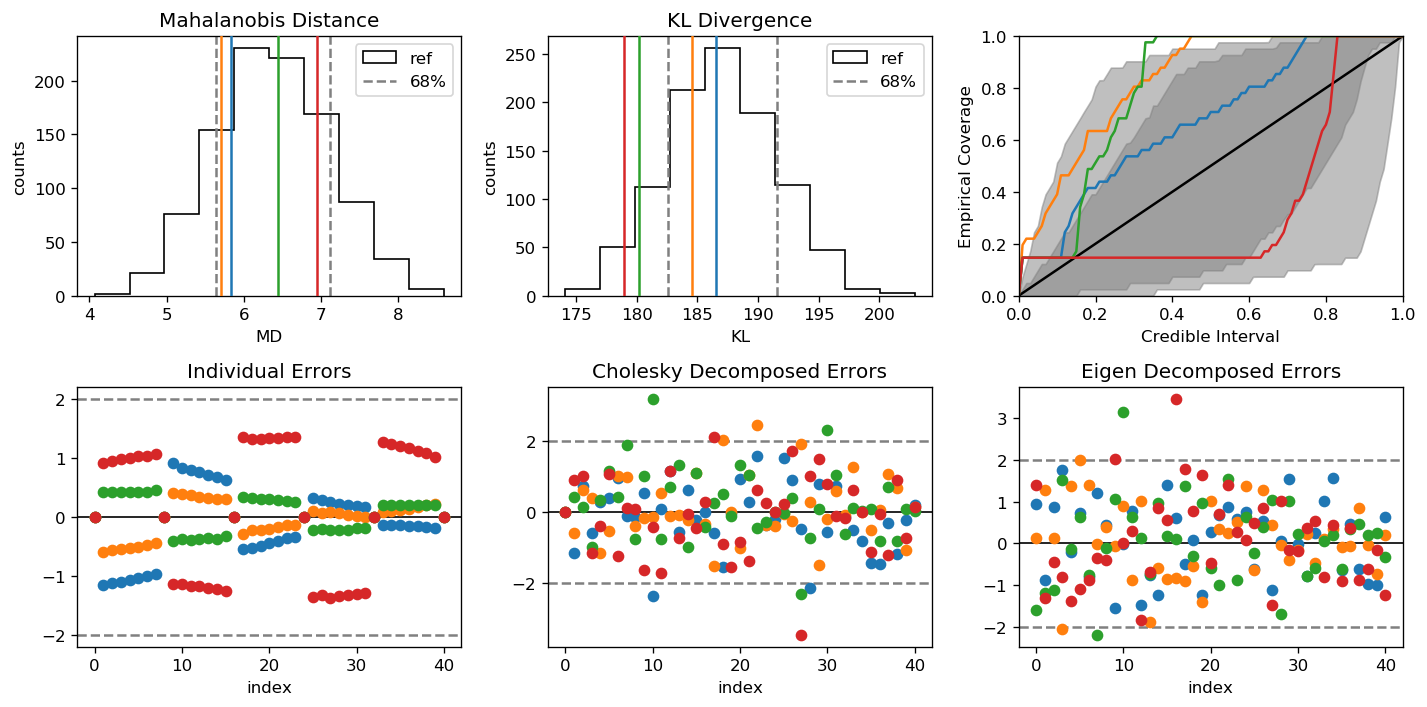

In [12]:
np.random.seed(seed)
gp = GP(kernel)
gpmc = GPModelChecking(np.zeros(m_pred.shape[1]), K_pred + nugget_sd**2 * np.eye(K_pred.shape[0]))
gd = GraphicalDiagnostic(gpmc, toy_data_full - m_pred, nref=n_ref)
gd.plotzilla(X_new, gp, predict=True);

These all look good! We should note that a nugget should be used across **all** covariances or else problems with ill-conditioned matrices arise.

Note that my answers tend to differ when computing, for example, the KL divergence when I use the "clever" method of combining diagnostics, although they are qualitatively similar:

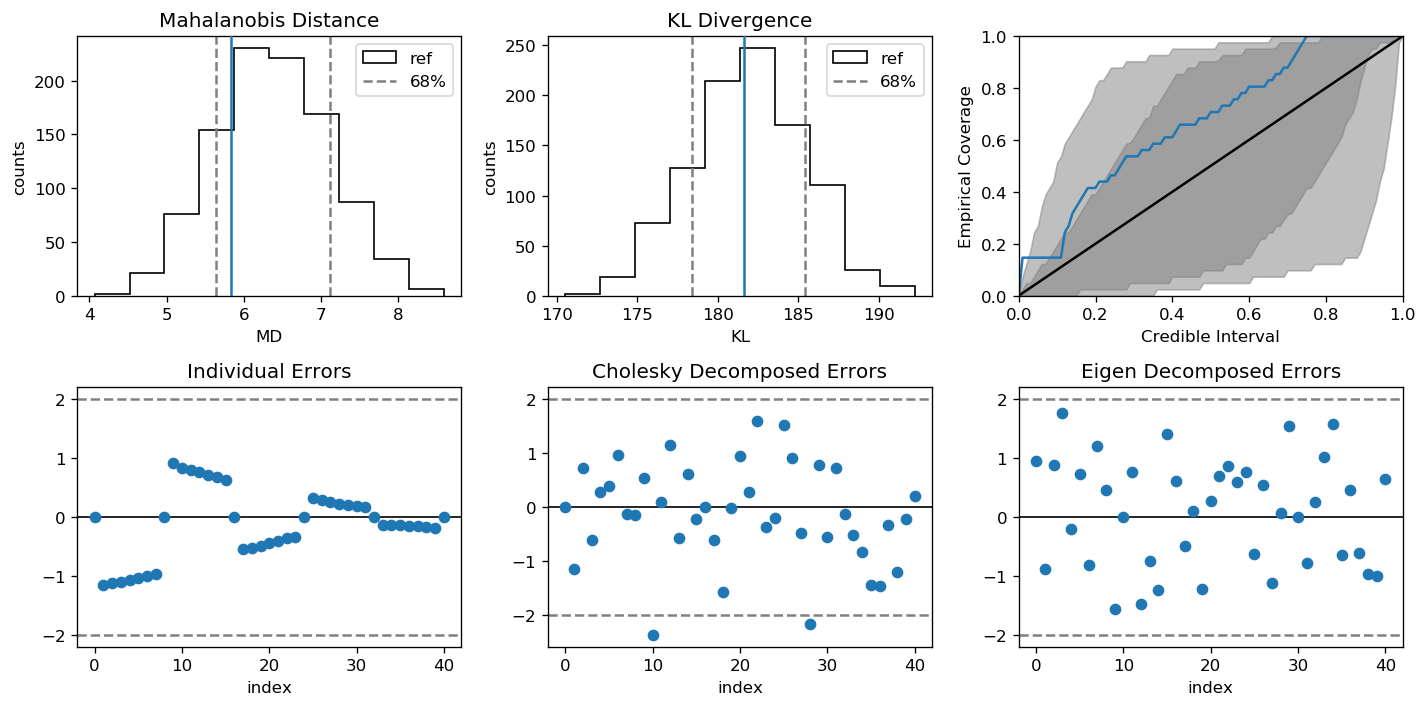

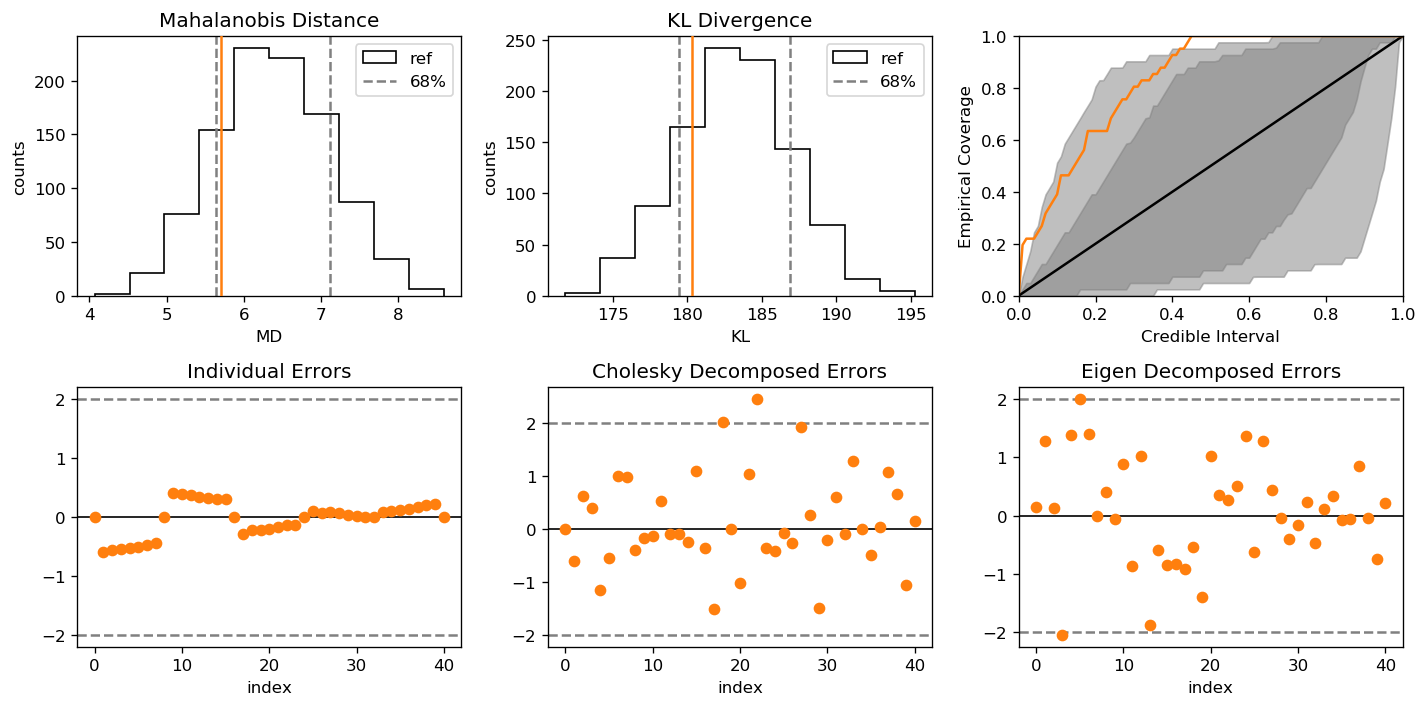

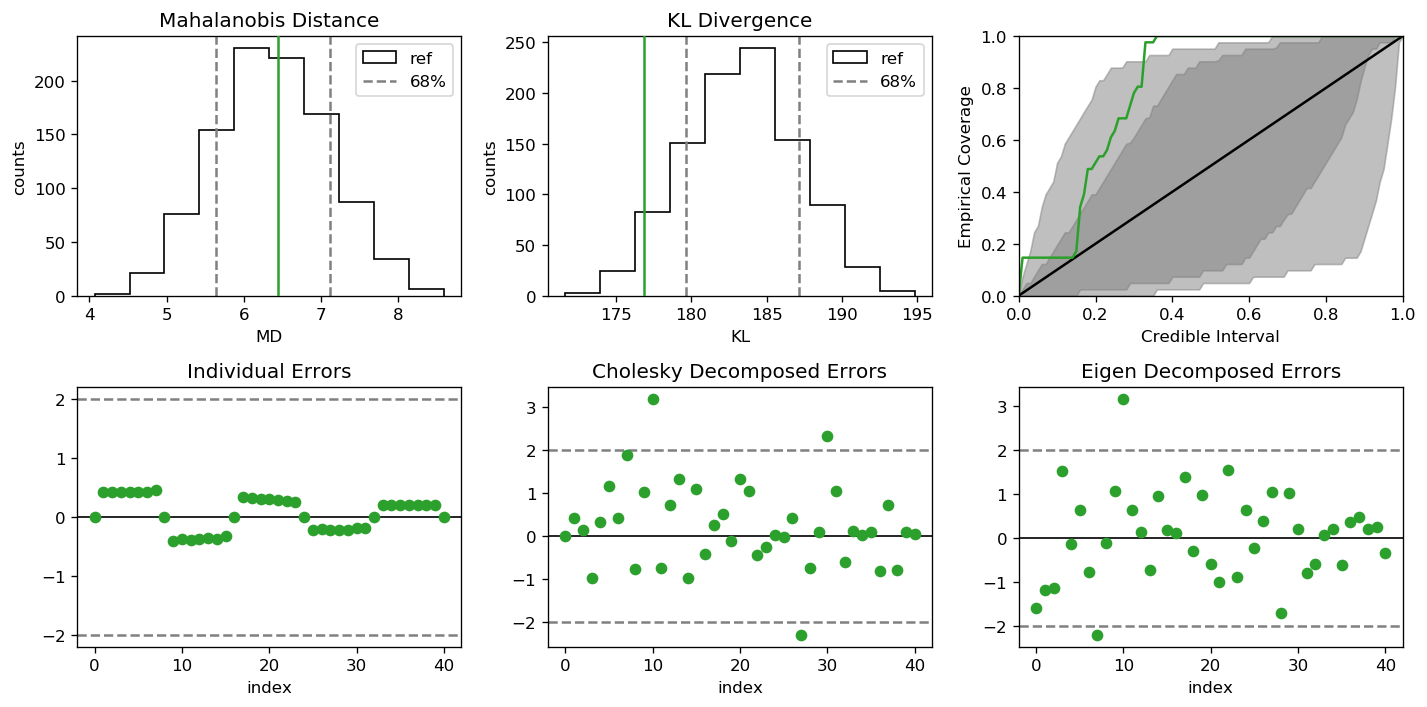

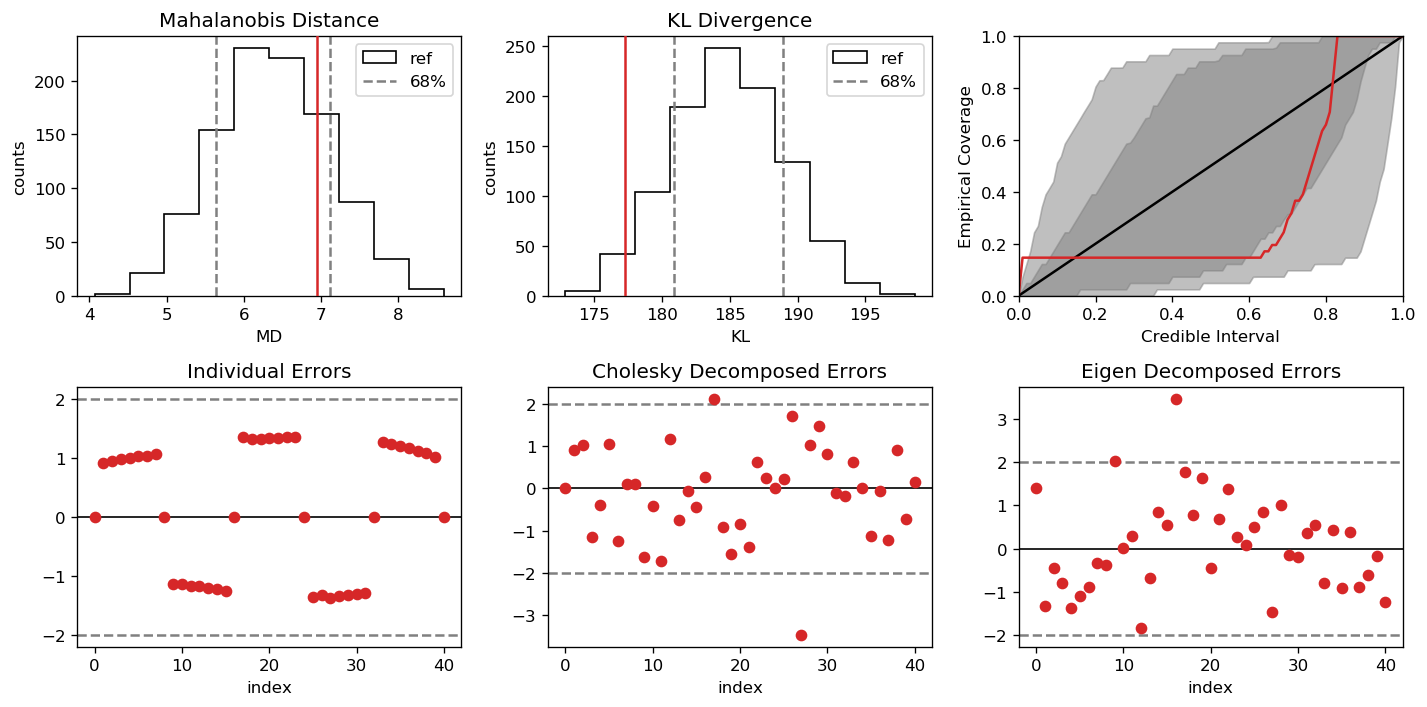

In [13]:
gp = GP(kernel)
# Matplotlib 2.0 colors
new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

for i, color in zip(range(len(toy_data)), cycle(new_colors)):
    np.random.seed(seed)
    # print('curve ' + str(i))
    gpmc = GPModelChecking(m_pred[i], K_pred + nugget_sd**2 * np.eye(K_pred.shape[0]))
    gd = GraphicalDiagnostic(gpmc, toy_data_full[i], nref=n_ref, colors=[color])
    gd.plotzilla(X_new, gp, predict=True);

## Todo

I want to improve the code, check for bugs/errors, add more examples, and add more model checking diagnostics. We must find where the model fails, and which diagnostics are most helpful when accepting/rejecting the model.